In this notebook we will see how to embed a batch of sequences using ESM C, as well as explore its different layers

In [1]:
# Import Required Libraries
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/'Colab Notebooks'/'Computational Analysis of Moonlighting Proteins'/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/Computational Analysis of Moonlighting Proteins


# Set up Forge client for ESM C

Grab a token from [the Forge console](https://forge.evolutionaryscale.ai/console) and add it below. Note that your token is like a password for your account and you should take care to protect it. For this reason it is recommended to frequently create a new token and delete old, unused ones. It is also recommended to paste the token directly into an environment variable or use a utility like `getpass` as shown below so tokens are not accidentally shared or checked into code repositories.

In [2]:
# Install esm and other dependencies
! pip install esm
! pip install matplotlib

In [3]:
from getpass import getpass

token = getpass("Token from Forge console: ")

Token from Forge console: ··········


In [4]:
from esm.sdk import client

model = client(
    model="esmc-300m-2024-12", url="https://forge.evolutionaryscale.ai", token=token
)

# Set up utilities for embedding sequences

Since we're embedding more than a few sequences, we're going to use a threaded async call to Forge and let Forge take care of batching and parallelization on the backend.

In [6]:
from concurrent.futures import ThreadPoolExecutor, as_completed
from typing import Sequence

from tqdm import tqdm  # Import tqdm for progress tracking

from esm.sdk.api import (
    ESM3InferenceClient,
    ESMProtein,
    ESMProteinError,
    LogitsConfig,
    LogitsOutput,
    ProteinType,
)

EMBEDDING_CONFIG = LogitsConfig(
    sequence=True, return_embeddings=True, return_hidden_states=True
)


def embed_sequence(model: ESM3InferenceClient, sequence: str) -> LogitsOutput:
    protein = ESMProtein(sequence=sequence)
    protein_tensor = model.encode(protein)
    output = model.logits(protein_tensor, EMBEDDING_CONFIG)
    return output

def batch_embed(
    model: ESM3InferenceClient, inputs: Sequence[ProteinType]
) -> Sequence[LogitsOutput]:
    """Forge supports auto-batching. So batch_embed() runs embed calls in parallel with a progress bar."""

    results = []
    with ThreadPoolExecutor() as executor:
        futures = {executor.submit(embed_sequence, model, protein): protein for protein in inputs}

        # Wrap futures in tqdm to show progress
        for future in tqdm(as_completed(futures), total=len(futures), desc="Embedding Sequences"):
            try:
                results.append(future.result())
            except Exception as e:
                results.append(ESMProteinError(500, str(e)))

            torch.cuda.empty_cache()
    return results

# Requesting a specific hidden layer

ESM C 6B's hidden states are really large, so we only allow one specific layer to be requested per API call. This also works for other ESM C models, but it is required for ESM C 6B.
Refer to https://forge.evolutionaryscale.ai/console to find the number of hidden layers for each model.

In [ ]:
# ESMC_6B_EMBEDDING_CONFIG = LogitsConfig(return_hidden_states=True, ith_hidden_layer=55)

# Load dataset

This dataset is taken from Muir, et al. 2024 ["Evolutionary-Scale Enzymology Enables Biochemical Constant Prediction Across a Multi-Peaked Catalytic Landscape"](https://doi.org/10.1101/2024.10.23.619915) which explores a model enzyme called Adenylate Kinase (ADK). Adenylate Kinase appears in many different organisms with different structural classes (referred to as its "lid type"). We'll embed this set of ADK sequences and see if we can recover known structural classes.

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

df = pd.read_csv("../predictor_dataset.csv")
df_200_to_500 = df.iloc[100:501]

In [ ]:
# You may see some error messages due to rate limits on each Forge account,
# but this will retry until the embedding job is complete
# This may take a few minutes to run
outputs = batch_embed(model, df_200_to_500["Amino Acid Sequence"].tolist())

Embedding Sequences:   0%|          | 0/401 [00:07<?, ?it/s]


In [ ]:
import torch

# Define a placeholder tensor with the same shape as a valid output's hidden_states
placeholder_tensor = torch.zeros_like(outputs[0].hidden_states)

# Replace ESMProteinError objects with the placeholder tensor
valid_outputs = [output.hidden_states if not isinstance(output, ESMProteinError) else placeholder_tensor for output in outputs]
print(f"Number of valid outputs: {len(valid_outputs)} from {len(outputs)}")

# Compute mean embeddings for all outputs, including placeholders
all_mean_embeddings = [
    torch.mean(output, dim=-2).squeeze() for output in valid_outputs
]

# Now we have a list of tensors of shape [num_layers, hidden_size]
print("embedding shape [num_layers, hidden_size]:", all_mean_embeddings[0].shape)

In [ ]:
# Save embeddings with numpy
import numpy as np

np.save("all_mean_embeddings_200_to_500.npy", all_mean_embeddings)

In [13]:
len(all_mean_embeddings[0])

31

# Examine the performance of different layer embeddings

For this example, we're going to use PCA to visualize whether the embeddings separate our proteins by their structural class. To assess the quality of our PCA, we fit a K means classifier with three clusters, corresponding to the three structural classes of our enzyme, and compute the [rand index](https://en.wikipedia.org/wiki/Rand_index), a measure of the quality of the clustering.

In [ ]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score

N_KMEANS_CLUSTERS = 3

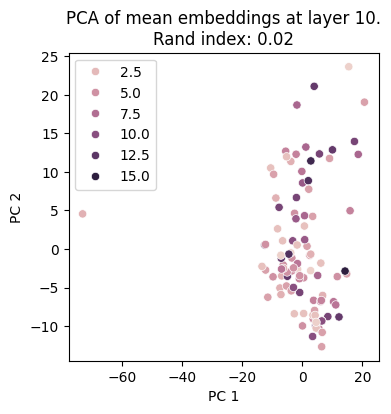

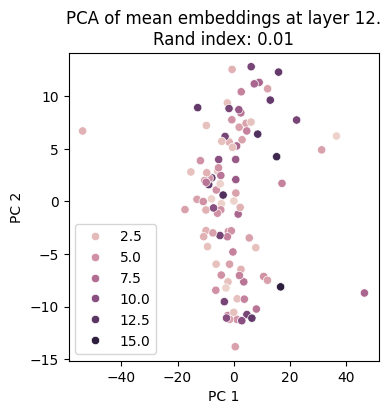

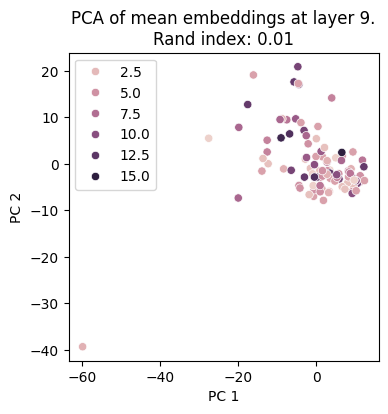

Top layers: [(10, 0.02014313056284059), (12, 0.014208751621683122), (9, 0.013622826071206994)]


In [ ]:
import torch
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
import matplotlib.pyplot as plt
import seaborn as sns

def find_best_layers(all_mean_embeddings: torch.Tensor, n_clusters: int, labels: list, top_n: int = 3):
    layer_rand_indices = []

    for layer_idx in range(all_mean_embeddings[0].shape[0]):
        stacked_mean_embeddings = torch.stack(
            [embedding[layer_idx, :] for embedding in all_mean_embeddings]
        ).numpy()

        # Project all the embeddings to 2D using PCA
        pca = PCA(n_components=2)
        pca.fit(stacked_mean_embeddings)
        projected_mean_embeddings = pca.transform(stacked_mean_embeddings)

        # Compute kmeans purity as a measure of how good the clustering is
        kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(projected_mean_embeddings)
        rand_index = adjusted_rand_score(labels, kmeans.labels_)

        # Store the Rand index and layer index
        layer_rand_indices.append((layer_idx, rand_index))

    # Sort layers by Rand index in descending order and select the top N layers
    top_layers = sorted(layer_rand_indices, key=lambda x: x[1], reverse=True)[:top_n]

    for layer_idx, rand_index in top_layers:
        stacked_mean_embeddings = torch.stack(
            [embedding[layer_idx, :] for embedding in all_mean_embeddings]
        ).numpy()

        # Project all the embeddings to 2D using PCA
        pca = PCA(n_components=2)
        pca.fit(stacked_mean_embeddings)
        projected_mean_embeddings = pca.transform(stacked_mean_embeddings)

        # Plot the clusters
        plt.figure(figsize=(4, 4))
        sns.scatterplot(
            x=projected_mean_embeddings[:, 0],
            y=projected_mean_embeddings[:, 1],
            hue=labels,
        )
        plt.title(f"PCA of mean embeddings at layer {layer_idx}.\nRand index: {rand_index:.2f}")
        plt.xlabel("PC 1")
        plt.ylabel("PC 2")
        plt.show()

    return top_layers

# Example usage
# Assuming `all_mean_embeddings` is a list of tensors of shape [num_layers, hidden_size]
# and `df_non_human_sample["Highest_MBL"]` contains the labels
top_layers = find_best_layers(all_mean_embeddings, N_KMEANS_CLUSTERS, df_non_human_sample["Highest_MBL"].tolist())
print(f"Top layers: {top_layers}")